# Capstone Project - The Battle of the Neighborhoods

#### Tomas Dmitrijevas

## 1. Introduction

Young and highly motivated business entrepreneurs are willing to help their city and open a new Pizza restaurant. There are many details and risks to be considered when opening a restaurant. The problem to decide on a most suitable city location for a new venture is in question.
For decision on a suitable place to be made, some of the factors need to be analysed:
- population of the neighborhood
- area of the neighborhood
- number of competitors in the neighborhood.

In this project, the most suitable location for a new Pizza restaurant will be analysed based on above mentioned criterias and insights for business owners will be provided based on conducted modeling of Vilnius neighborhood locations.

## 2. Data
### 2.1 Data Description

Data for the project was retrieved from from several public data sources. Data sources that are used for further data analysis of the project:

    1. “Neighborhoods of Vilnius”. Source: https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius
    - List of neighborhoods of Vilnius, Lithuania
    - Area, km2 of Vilnius neighborhoods
    - Population of Vilnius neighborhoods
    2. Foursquare API:
    - Data of the venues that are located in Vilnius neighborhoods in defined radius
    3. Geolocator API
    - Latitude and Longitude coordinates of analysed locations
    
All retrieved data was investigated, cleaned and adjusted, if needed, using these data manipulation methods:
    1. Unnecessary symbols cleaning
    2. Unnecessary data columns dropping
    3. Conversion of features to a correct data type
    4. Value sorting
    5. Value aggregation

### 2.2 Data Preparation

• Importing all required libraries needed for the project.

In [351]:
# Import relevant libraries
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests

import geocoder # import geocoder
import folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.spatial.distance import cdist 
from yellowbrick.cluster import KElbowVisualizer

• Loading data from the web table into Dataframe

In [352]:
# Scrape url for table
url = 'https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius'
req = requests.get(url)
soup = BeautifulSoup(req.content,'html.parser')

table = soup.find('table', attrs={'class':'sortable wikitable'})

• Cleaning data

In [353]:
# Create DataFrame from scraped data
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
df = pd.DataFrame(l, columns=['No.', 'Neighborhood', 'Area', 'Population', 'Density', 'Latitude', 'Longitude'])
df.head()

,No.,Neighborhood,Area,Population,Density,Latitude,Longitude
0,None,None,None,None,None,None,None
1,1\n,Verkiai\n,56.0\n,"30,856\n",551.0\n,54.708707\n,25.284686\n
2,2\n,Antakalnis\n,77.2\n,"39,697\n",514.2\n,54.701126\n,25.308957\n
3,3\n,Pašilaičiai\n,7.9\n,"25,674\n","3,249.9\n",54.725942\n,25.231328\n
4,4\n,Fabijoniškės\n,5.9\n,"36,644\n","6,210.8\n",54.723397\n,25.249529\n


In [354]:
# Drop first line of dataframe values
df.drop(0, inplace=True, axis=0)
df.drop('No.', inplace=True, axis=1)
df.head()

,Neighborhood,Area,Population,Density,Latitude,Longitude
1,Verkiai\n,56.0\n,"30,856\n",551.0\n,54.708707\n,25.284686\n
2,Antakalnis\n,77.2\n,"39,697\n",514.2\n,54.701126\n,25.308957\n
3,Pašilaičiai\n,7.9\n,"25,674\n","3,249.9\n",54.725942\n,25.231328\n
4,Fabijoniškės\n,5.9\n,"36,644\n","6,210.8\n",54.723397\n,25.249529\n
5,Pilaitė\n,13.9\n,"15,996\n","1,150.8\n",54.708126\n,25.175803\n


In [355]:
# Clean data
columns=['Neighborhood', 'Area', 'Population', 'Density', 'Latitude', 'Longitude']

for col in columns:
    df[col] = [x.replace('\n','') for x in df[col]]

df.reset_index(drop=True, inplace=True)
df.head()

,Neighborhood,Area,Population,Density,Latitude,Longitude
0,Verkiai,56.0,"30,856",551.0,54.708707,25.284686
1,Antakalnis,77.2,"39,697",514.2,54.701126,25.308957
2,Pašilaičiai,7.9,"25,674","3,249.9",54.725942,25.231328
3,Fabijoniškės,5.9,"36,644","6,210.8",54.723397,25.249529
4,Pilaitė,13.9,"15,996","1,150.8",54.708126,25.175803


In [356]:
# Analyse dataframe shape and data types columns
print(df.shape)
print(df.dtypes)

(21, 6)
Neighborhood    object
Area            object
Population      object
Density         object
Latitude        object
Longitude       object
dtype: object


• Next steps in Data cleaning:
    - Ambiguous data such as 'Density' may be calculated by dividing 'Population' by 'Area'. For this reason, it was decided to keep 'Area' and 'Population' data columns and drop 'Density' column. Area and population statistics of neighborhoods might help to come with a final decision of a new Pizza restaurant place.
    - Data provided in the web might be outdated. It was decided to keep the list of the Vilnius neighborhoods but update the neighborhood center locations using Geolocator coordinates.

In [357]:
# Drop columns
df.drop(['Density', 'Latitude', 'Longitude'], axis=1, inplace=True)

In [358]:
### Update neighborhood coordinates
# Create empty lists
coord_lat = []
coord_long = []
no_coord = []

# Loop through Neighborhood names to get Geolocator longitude and latitude data
for address in df['Neighborhood']:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address + ', Vilnius, Lithuania')
    if location is None:
        latitude = np.nan
        longitude = np.nan
        no_coord.append(address)
    else: 
        latitude = location.latitude
        longitude = location.longitude 
    
    coord_lat.append(latitude)
    coord_long.append(longitude)
    
df['Latitude'] = coord_lat
df['Longitude'] = coord_long

df

,Neighborhood,Area,Population,Latitude,Longitude
0,Verkiai,56.0,"30,856",54.750657,25.294767
1,Antakalnis,77.2,"39,697",54.705639,25.314538
2,Pašilaičiai,7.9,"25,674",54.728487,25.228916
3,Fabijoniškės,5.9,"36,644",54.726411,25.249242
4,Pilaitė,13.9,"15,996",54.705676,25.183502
5,Justiniškės,3.0,"30,958",54.717860,25.220205
6,Viršuliškės,2.6,"16,250",54.705351,25.228871
7,Šeškinė,4.6,"36,604",54.712653,25.252203
8,Šnipiškės,3.1,"19,321",54.701755,25.278558
9,Žirmūnai,5.7,"47,410",54.711172,25.298810


In [359]:
# Convert column values to float
df['Area'] = df['Area'].astype(float)
df['Population'] = [float(x.replace(',','')) for x in df['Population']]
df.dtypes

Neighborhood     object
Area            float64
Population      float64
Latitude        float64
Longitude       float64
dtype: object

In [360]:
# Sort dataframe values in ascending alphabetical neighborhood order
df.sort_values('Neighborhood', ascending=True, inplace=True)
df.reset_index(inplace=True,drop=True)
df

,Neighborhood,Area,Population,Latitude,Longitude
0,Antakalnis,77.2,39697.0,54.705639,25.314538
1,Fabijoniškės,5.9,36644.0,54.726411,25.249242
2,Grigiškės,7.0,11617.0,54.674493,25.089082
3,Justiniškės,3.0,30958.0,54.717860,25.220205
4,Karoliniškės,3.7,31175.0,54.693085,25.213158
5,Lazdynai,9.9,32164.0,54.676035,25.209932
6,Naujamiestis,4.9,27892.0,54.680996,25.265121
7,Naujininkai,37.6,33457.0,54.661222,25.271826
8,Naujoji Vilnia,38.6,32775.0,54.695211,25.403053
9,Paneriai,84.8,8909.0,54.629718,25.177071


• Get coordinates of Vilnius, Lithuania

In [361]:
address = 'Vilnius, Lithuania'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Vilnius are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vilnius are 54.6870458, 25.2829111.


• Visualise Vilnius neighborhood centerpoints on map of Vilnius, Lithuania

In [362]:
map_vilnius = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vilnius)
    
map_vilnius


• Define Foursquare credentials

In [363]:
CLIENT_ID = 'SNGXJMOYT2NUM01GKNNAI44PUDNLI1DIIX0VCOLM5SEGS22P' # your Foursquare ID
CLIENT_SECRET = 'XG4KYI0K3VBDGFFFTG2WJPQIWYLCVXJSSP3QFJNFVFBGJKF0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SNGXJMOYT2NUM01GKNNAI44PUDNLI1DIIX0VCOLM5SEGS22P
CLIENT_SECRET:XG4KYI0K3VBDGFFFTG2WJPQIWYLCVXJSSP3QFJNFVFBGJKF0


• Define function to get venues of neighborhoods

In [364]:
def getNearbyVenues(names, latitudes, longitudes, radius):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

• Get venues of Vilnius neighborhoods

In [365]:
vilnius_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                radius=radius
                                  )

Antakalnis
Fabijoniškės
Grigiškės
Justiniškės
Karoliniškės
Lazdynai
Naujamiestis
Naujininkai
Naujoji Vilnia
Paneriai
Pašilaičiai
Pilaitė
Rasos
Senamiestis
Verkiai
Vilkpėdė
Viršuliškės
Šeškinė
Šnipiškės
Žirmūnai
Žvėrynas


In [366]:
print('{} venues received for Vilnius, Lithuania neighborhoods.' .format(vilnius_venues.shape[0]))
vilnius_venues.head()

725 venues received for Vilnius, Lithuania neighborhoods.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Antakalnis,54.705639,25.314538,Active Gym,54.703708,25.310606,Gym / Fitness Center
1,Antakalnis,54.705639,25.314538,Visa Pica,54.703777,25.316647,Pizza Place
2,Antakalnis,54.705639,25.314538,G7 Sporto klubas,54.701748,25.315078,Gym / Fitness Center
3,Antakalnis,54.705639,25.314538,Lemon Gym Antakalnis,54.703726,25.310632,Gym
4,Antakalnis,54.705639,25.314538,Taste Map Coffee Park,54.699220,25.309442,Coffee Shop


In [367]:
vilnius_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Antakalnis,27,27,27,27,27,27
Fabijoniškės,37,37,37,37,37,37
Grigiškės,4,4,4,4,4,4
Justiniškės,15,15,15,15,15,15
Karoliniškės,12,12,12,12,12,12
Lazdynai,15,15,15,15,15,15
Naujamiestis,100,100,100,100,100,100
Naujininkai,23,23,23,23,23,23
Naujoji Vilnia,8,8,8,8,8,8


In [368]:
print('The are {} Pizza place venues in Vilnius'.format(vilnius_venues[vilnius_venues['Venue Category'].isin(['Pizza Place', 'Italian Restaurant'])].shape[0]))

The are 42 Pizza place venues in Vilnius


In [369]:
# Check how many Pizza places are in every neighborhood
vilnius_pizza_ngh = vilnius_venues[vilnius_venues['Venue Category'].isin(['Pizza Place', 'Italian Restaurant'])].groupby(['Neighborhood']).count()
vilnius_pizza_ngh.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis=1, inplace=True)
vilnius_pizza_ngh.rename(columns = {'Venue':'No. of Pizza places'}, inplace=True)
vilnius_pizza_ngh

,No. of Pizza places
Neighborhood,
Antakalnis,2
Fabijoniškės,2
Justiniškės,1
Lazdynai,1
Naujamiestis,5
Naujininkai,2
Naujoji Vilnia,1
Pašilaičiai,2
Rasos,4


In [370]:
# Join neighborhood Pizza place statistics to dataframe
df = df.join(vilnius_pizza_ngh, on='Neighborhood')
df.head()

,Neighborhood,Area,Population,Latitude,Longitude,No. of Pizza places
0,Antakalnis,77.2,39697.0,54.705639,25.314538,2.0
1,Fabijoniškės,5.9,36644.0,54.726411,25.249242,2.0
2,Grigiškės,7.0,11617.0,54.674493,25.089082,NaN
3,Justiniškės,3.0,30958.0,54.717860,25.220205,1.0
4,Karoliniškės,3.7,31175.0,54.693085,25.213158,NaN


In [371]:
# Fill missing values with 0
df = df.fillna(0)
df

,Neighborhood,Area,Population,Latitude,Longitude,No. of Pizza places
0,Antakalnis,77.2,39697.0,54.705639,25.314538,2.0
1,Fabijoniškės,5.9,36644.0,54.726411,25.249242,2.0
2,Grigiškės,7.0,11617.0,54.674493,25.089082,0.0
3,Justiniškės,3.0,30958.0,54.717860,25.220205,1.0
4,Karoliniškės,3.7,31175.0,54.693085,25.213158,0.0
5,Lazdynai,9.9,32164.0,54.676035,25.209932,1.0
6,Naujamiestis,4.9,27892.0,54.680996,25.265121,5.0
7,Naujininkai,37.6,33457.0,54.661222,25.271826,2.0
8,Naujoji Vilnia,38.6,32775.0,54.695211,25.403053,1.0
9,Paneriai,84.8,8909.0,54.629718,25.177071,0.0


## 3. Analysis

• Prepare data features for cluster analysis

In [372]:
df_clusters = df.drop(['Neighborhood','Latitude', 'Longitude'],axis = 1)
df_clusters.head()

,Area,Population,No. of Pizza places
0,77.2,39697.0,2.0
1,5.9,36644.0,2.0
2,7.0,11617.0,0.0
3,3.0,30958.0,1.0
4,3.7,31175.0,0.0


• Standardise data features with StandardScaler

In [373]:
from sklearn.preprocessing import StandardScaler
df_clusters = StandardScaler().fit_transform(df_clusters)
df_clusters

array([[ 2.3811244 ,  1.32307443,  0.        ],
       [-0.53954207,  1.02567319,  0.        ],
       [-0.4944827 , -1.41227672, -1.12815215],
       [-0.65833496,  0.47178406, -0.56407607],
       [-0.62966081,  0.49292264, -1.12815215],
       [-0.37568982,  0.58926388, -0.56407607],
       [-0.58050514,  0.17311644,  1.69222822],
       [ 0.75898706,  0.71521862,  0.        ],
       [ 0.79995012,  0.6487831 , -0.56407607],
       [ 2.69244369, -1.67607055, -1.12815215],
       [-0.45761595, -0.04294512,  0.        ],
       [-0.21183756, -0.98570611, -1.12815215],
       [-0.11352621, -1.27229454,  1.12815215],
       [-0.60098667, -0.49610943,  1.12815215],
       [ 1.51270744,  0.46184796, -1.12815215],
       [-0.33882306, -0.13305196, -1.12815215],
       [-0.67472019, -0.96096326,  0.        ],
       [-0.59279406,  1.02177667,  0.56407607],
       [-0.65423865, -0.66180858,  2.2563043 ],
       [-0.54773469,  2.07441929,  1.12815215],
       [-0.67472019, -1.35665402,  0.564

• Use kMeans Elbow method to finding the optimal number of clusters 

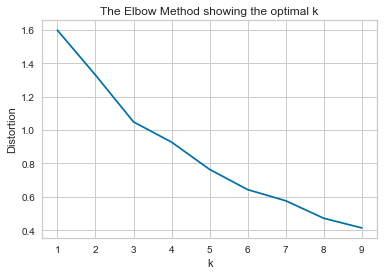

In [374]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_clusters)
    kmeanModel.fit(df_clusters)
    distortions.append(sum(np.min(cdist(df_clusters, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_clusters.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

No clear optimal number of clusters was identified.

• Use Silhouette method to find the optimal number of clusters

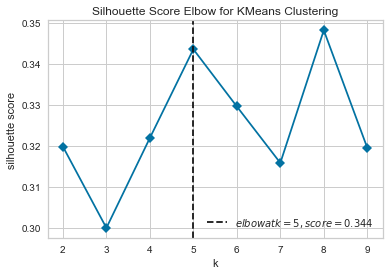

In [375]:
visualizer = KElbowVisualizer(kmeanModel, k=(2,10), metric='silhouette', timings=False)
visualizer.fit(df_clusters)    
visualizer.poof()
plt.show()

• Fit kMean clustering model with standardized features and get cluster labels for neighborhoods

In [376]:
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 1, 6, 6, 6, 5, 3, 3, 4])

In [377]:
# add cluster labels to dataframe
df.insert(0, 'Cluster Labels', kmeans.labels_)
vilnius_merged = df
vilnius_merged.head()

,Cluster Labels,Neighborhood,Area,Population,Latitude,Longitude,No. of Pizza places
0,3,Antakalnis,77.2,39697.0,54.705639,25.314538,2.0
1,0,Fabijoniškės,5.9,36644.0,54.726411,25.249242,2.0
2,1,Grigiškės,7.0,11617.0,54.674493,25.089082,0.0
3,6,Justiniškės,3.0,30958.0,54.717860,25.220205,1.0
4,6,Karoliniškės,3.7,31175.0,54.693085,25.213158,0.0


• Plot the map of Vilnius with clustered neighborhoods
    - different colors for separate neighborhoods clusters
    - bubble size based on neighborhood population size

In [378]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, pop, pizza in zip(vilnius_merged['Latitude'], vilnius_merged['Longitude'], vilnius_merged['Neighborhood'], vilnius_merged['Cluster Labels'],vilnius_merged['Population'], vilnius_merged['No. of Pizza places']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Pizza places ' + str(pizza), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5*pop/10000,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

• Inspect clusters

In [379]:
cluster_1 = vilnius_merged.loc[vilnius_merged['Cluster Labels'] == 0, vilnius_merged.columns[list(range(0, 4)) + [6]]]
cluster_1

,Cluster Labels,Neighborhood,Area,Population,No. of Pizza places
1,0,Fabijoniškės,5.9,36644.0,2.0
17,0,Šeškinė,4.6,36604.0,3.0
19,0,Žirmūnai,5.7,47410.0,4.0


In [380]:
cluster_2 = vilnius_merged.loc[vilnius_merged['Cluster Labels'] == 1, vilnius_merged.columns[list(range(0, 4)) + [6]]]
cluster_2

,Cluster Labels,Neighborhood,Area,Population,No. of Pizza places
2,1,Grigiškės,7.0,11617.0,0.0
11,1,Pilaitė,13.9,15996.0,0.0


In [381]:
cluster_3 = vilnius_merged.loc[vilnius_merged['Cluster Labels'] == 2, vilnius_merged.columns[list(range(0, 4)) + [6]]]
cluster_3

,Cluster Labels,Neighborhood,Area,Population,No. of Pizza places
12,2,Rasos,16.3,13054.0,4.0
16,2,Viršuliškės,2.6,16250.0,2.0
20,2,Žvėrynas,2.6,12188.0,3.0


In [382]:
cluster_4 = vilnius_merged.loc[vilnius_merged['Cluster Labels'] == 3, vilnius_merged.columns[list(range(0, 4)) + [6]]]
cluster_4

,Cluster Labels,Neighborhood,Area,Population,No. of Pizza places
0,3,Antakalnis,77.2,39697.0,2.0
7,3,Naujininkai,37.6,33457.0,2.0
8,3,Naujoji Vilnia,38.6,32775.0,1.0
14,3,Verkiai,56.0,30856.0,0.0


In [383]:
cluster_5 = vilnius_merged.loc[vilnius_merged['Cluster Labels'] == 4, vilnius_merged.columns[list(range(0, 4)) + [6]]]
cluster_5

,Cluster Labels,Neighborhood,Area,Population,No. of Pizza places
9,4,Paneriai,84.8,8909.0,0.0


In [384]:
cluster_6 = vilnius_merged.loc[vilnius_merged['Cluster Labels'] == 5, vilnius_merged.columns[list(range(0, 4)) + [6]]]
cluster_6

,Cluster Labels,Neighborhood,Area,Population,No. of Pizza places
6,5,Naujamiestis,4.9,27892.0,5.0
13,5,Senamiestis,4.4,21022.0,4.0
18,5,Šnipiškės,3.1,19321.0,6.0


In [385]:
cluster_7 = vilnius_merged.loc[vilnius_merged['Cluster Labels'] == 6, vilnius_merged.columns[list(range(0, 4)) + [6]]]
cluster_7

,Cluster Labels,Neighborhood,Area,Population,No. of Pizza places
3,6,Justiniškės,3.0,30958.0,1.0
4,6,Karoliniškės,3.7,31175.0,0.0
5,6,Lazdynai,9.9,32164.0,1.0
10,6,Pašilaičiai,7.9,25674.0,2.0
15,6,Vilkpėdė,10.8,24749.0,0.0


In [386]:
standardized_df = pd.DataFrame(df_clusters, columns=['standard_area', 'standard_pop', 'standard_pizza'])
standardized_df = vilnius_merged.join(standardized_df, on=standardized_df.index)
standardized_df

,Cluster Labels,Neighborhood,Area,Population,Latitude,Longitude,No. of Pizza places,standard_area,standard_pop,standard_pizza
0,3,Antakalnis,77.2,39697.0,54.705639,25.314538,2.0,2.381124,1.323074,0.000000
1,0,Fabijoniškės,5.9,36644.0,54.726411,25.249242,2.0,-0.539542,1.025673,0.000000
2,1,Grigiškės,7.0,11617.0,54.674493,25.089082,0.0,-0.494483,-1.412277,-1.128152
3,6,Justiniškės,3.0,30958.0,54.717860,25.220205,1.0,-0.658335,0.471784,-0.564076
4,6,Karoliniškės,3.7,31175.0,54.693085,25.213158,0.0,-0.629661,0.492923,-1.128152
5,6,Lazdynai,9.9,32164.0,54.676035,25.209932,1.0,-0.375690,0.589264,-0.564076
6,5,Naujamiestis,4.9,27892.0,54.680996,25.265121,5.0,-0.580505,0.173116,1.692228
7,3,Naujininkai,37.6,33457.0,54.661222,25.271826,2.0,0.758987,0.715219,0.000000
8,3,Naujoji Vilnia,38.6,32775.0,54.695211,25.403053,1.0,0.799950,0.648783,-0.564076
9,4,Paneriai,84.8,8909.0,54.629718,25.177071,0.0,2.692444,-1.676071,-1.128152


• Visualise neighborhood sorted data

No handles with labels found to put in legend.


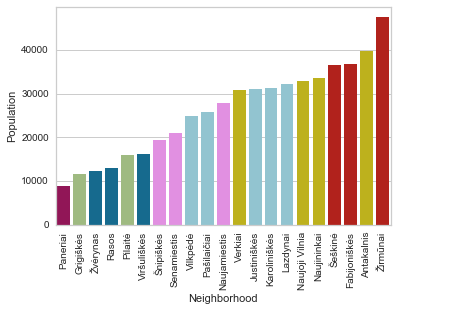

In [387]:
color_map = {0:'r', 1:'g', 2:'b', 3:'y', 4:'m', 5:'violet', 6:'c'}
#print([color_map[key] for key in standardized_df['Cluster Labels']])
g = sns.barplot(x='Neighborhood', 
                y='Population', 
                data=standardized_df.sort_values('Population'),                 
                palette=[color_map[key] for key in standardized_df.sort_values('Population')['Cluster Labels']])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.legend(loc='right', bbox_to_anchor=(1.25, 0.5))
plt.show()

No handles with labels found to put in legend.


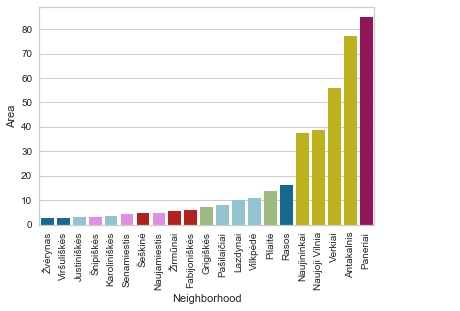

In [388]:
g = sns.barplot(x='Neighborhood', 
                y='Area', 
                data=standardized_df.sort_values('Area'),                 
                palette=[color_map[key] for key in standardized_df.sort_values('Area')['Cluster Labels']]
               )
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.legend(loc='right', bbox_to_anchor=(1.25, 0.5))
plt.show()

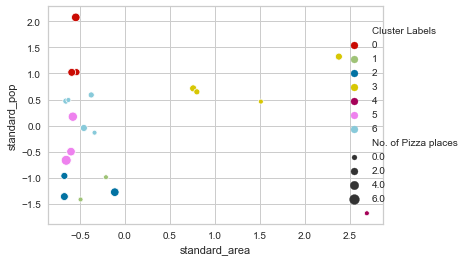

In [389]:
g = sns.scatterplot(x='standard_area',
                    y='standard_pop',
                    size='No. of Pizza places',
                    data=standardized_df,
                    hue='Cluster Labels',
                    palette=color_map
                   )
g.legend(loc='right', bbox_to_anchor=(1.25, 0.5))
plt.show()

## 4. Discussion and results

Visual inspection of clustered Vilnius neighborhoods identified that Paneriai neighborhood is only one observation in its cluster. It is a large area, low populated area which has no pizzerias. People may not be interested to have a new pizzeria in this area and going with a decision to open a restaurant there is risky.

Cluster 5 area neighborhoods such as Senamiestis, Naujamiestis, Šnipiškės are in the central part of Vilnius. It consists of relatively small and averagely populated neighborhoods. Opening new pizzeria might be risky move as many operating competitors are operating in the cluster. Of course, central part of the city is attraction to many city visitors and new restaurant might get some interest. The decision to open a restaurant in Cluster 5 neighborhoods depends on the strategy and risk assessment of the business.

Clustering model precisely identified the “sleeping” neighborhoods of Vilnius – Cluster 6 (Pašilaičiai, Justiniškės, Karoliniškės, Lazdynai, Vilkpėdė). These neighborhoods are highly populated areas with many blocks of flats, where many people homes are located. These neighborhoods have 0-2 pizzerias. While containing relatively small competition and high population the neighborhoods of cluster might be of high interest for the business to open a new Pizzeria in the area. Karoliniškės and Vilkpėdė are neighborhoods with 0 count venues of interest and might be a potential neighborhood to open a new pizza spot.

## 5. Conclusion

This project consists of basic data analysis that was conducted to identify a potential location for a new Pizza restaurant in Vilnius. Many other factors, such as purchasing power, other competitor strategy, work specifics, etc. are needed to be evaluated in the deeper analysis. Clustering analysis performed in this project revealed the possibility to suggest the user an optimal location for a new business based on some selected features and statistics.